# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


In [1]:
pip install shap


  Using cached shap-0.46.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.60.0-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached llvmlite-0.43.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
Using cached shap-0.46.0-cp311-cp311-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------------------


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: C:\Users\Anarchy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import shap
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

C:\Users\Anarchy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# The training data.
var_defs = pd.read_csv('variable_definitions.csv')
var_defs

Variable                                        Description
0              ID  The IDs take the form of [area ID]_yyyy-mm-dd....
1            area                                            Area ID
2            date          The date that the data is aggregated over
3             lat                 Latitude of the center of the area
4             lon                Longitude of the center of the area
5       burn_area                       Percentage of the area burnt
6     climate_aet  Actual evapotranspiration, derived using a one...
7     climate_def  Climate water deficit, derived using a one-dim...
8    climate_pdsi                      Palmer Drought Severity Index
9     climate_pet  Reference evapotranspiration (ASCE Penman-Mont...
10     climate_pr                         Precipitation accumulation
11     climate_ro  Runoff, derived using a one-dimensional soil w...
12   climate_soil  Soil moisture, derived using a one-dimensional...
13   climate_srad               Downward surface shortwave radiation
14    climate_swe  Snow water equivalent, derived using a one-dim...
15   climate_tmmn                                Minimum temperature
16   climate_tmmx                                Maximum temperature
17    climate_vap                                     Vapor pressure
18    climate_vpd                             Vapor pressure deficit
19     climate_vs                                  Wind-speed at 10m
20      elevation                                     Land elevation
21    landcover_0  Water Bodies: at least 60% of area is covered ...
22    landcover_1  Evergreen Needleleaf Vegetation: dominated by ...
23    landcover_2  Evergreen Broadleaf Vegetation: dominated by e...
24    landcover_3  Deciduous Needleleaf Vegetation: dominated by ...
25    landcover_4  Deciduous Broadleaf Vegetation: dominated by d...
26    landcover_5  Annual Broadleaf Vegetation: dominated by herb...
27    landcover_6  Annual Grass Vegetation: dominated by herbaceo...
28    landcover_7  Non-Vegetated Lands: at least 60% of area is n...
29    landcover_8  Urban and Built-up Lands: at least 30% impervi...
30  precipitation         Merged microwave/IR precipitation estimate

In [4]:
# The training data.
pd.set_option('display.max_columns', None)
train = pd.read_csv('Train.csv')
train.head()

ID        lat        lon  burn_area  climate_aet  climate_def  \
0  0_2001-01-01 -15.858835  29.237029        0.0         1195            0   
1  1_2001-01-01 -15.858835  29.487029        0.0         1196            0   
2  2_2001-01-01 -15.858835  29.737029        0.0         1190            0   
3  3_2001-01-01 -15.858835  29.987029        0.0         1144            0   
4  4_2001-01-01 -15.858835  30.237029        0.0         1187            0   

   climate_pdsi  climate_pet  climate_pr  climate_ro  climate_soil  \
0           263         1195         206          10          1692   
1           232         1196         201          10          1859   
2           314         1190         192          10          1677   
3           321         1144         186          66          1061   
4           413         1187         186           9          1714   

   climate_srad  climate_swe  climate_tmmn  climate_tmmx  climate_vap  \
0          1861            0           211           317         2493   
1          1867            0           211           318         2497   
2          1861            0           208           317         2486   
3          1864            0           196           303         2333   
4          1852            0           204           314         2426   

   climate_vpd  climate_vs   elevation  landcover_0  landcover_1  landcover_2  \
0          111         141  413.474762          0.0          0.0     0.018654   
1          112         138  429.034543          0.0          0.0     0.000000   
2          109         141  477.246432          0.0          0.0     0.000000   
3           98         124  646.388681          0.0          0.0     0.000000   
4          109         145  582.340637          0.0          0.0     0.000000   

   landcover_3  landcover_4  landcover_5  landcover_6  landcover_7  \
0          0.0     0.714446     0.012174     0.244890     0.009836   
1          0.0     0.654783     0.000095     0.345121     0.000000   
2          0.0     0.516421     0.000000     0.483579     0.000000   
3          0.0     0.299000     0.163902     0.537098     0.000000   
4          0.0     0.277392     0.067742     0.654866     0.000000   

   landcover_8  precipitation  
0          0.0       0.256932  
1          0.0       0.273093  
2          0.0       0.285109  
3          0.0       0.298418  
4          0.0       0.315621

In [5]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('Test.csv')
test.head(1)

ID        lat        lon  climate_aet  climate_def  climate_pdsi  \
0  0_2014-01-01 -15.858835  29.237029         1146           74          -451   

   climate_pet  climate_pr  climate_ro  climate_soil  climate_srad  \
0         1220         120           6           212          1974   

   climate_swe  climate_tmmn  climate_tmmx  climate_vap  climate_vpd  \
0            0           217           303         2481           99   

   climate_vs   elevation  landcover_0  landcover_1  landcover_2  landcover_3  \
0         148  413.474762          0.0     0.000615     0.015418          0.0   

   landcover_4  landcover_5  landcover_6  landcover_7  landcover_8  \
0     0.416704     0.023724     0.530016     0.013524          0.0   

   precipitation  
0       0.404243

# EDA + Feature Engineering

In [6]:
# Look at distribution of each variable
train.describe(include="all")

ID           lat           lon     burn_area   climate_aet  \
count          83148  83148.000000  83148.000000  83148.000000  83148.000000   
unique         83148           NaN           NaN           NaN           NaN   
top     0_2001-01-01           NaN           NaN           NaN           NaN   
freq               1           NaN           NaN           NaN           NaN   
mean             NaN    -19.014557     29.860856      0.007632    484.491124   
std              NaN      1.588444      1.751090      0.029226    470.467480   
min              NaN    -22.358835     25.487029      0.000000      0.000000   
25%              NaN    -20.358835     28.487029      0.000000     50.000000   
50%              NaN    -18.858835     29.987029      0.000000    302.000000   
75%              NaN    -17.858835     31.237029      0.000000    931.000000   
max              NaN    -15.858835     32.987029      0.843886   1713.000000   

         climate_def  climate_pdsi   climate_pet    climate_pr    climate_ro  \
count   83148.000000  83148.000000  83148.000000  83148.000000  83148.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      828.892721    -30.806237   1313.382992     54.576322      6.215134   
std       546.934469    235.802930    315.209838     71.997561     21.480399   
min         0.000000   -563.000000    587.000000      0.000000      0.000000   
25%       375.000000   -212.000000   1081.000000      1.000000      0.000000   
50%       858.000000   -108.000000   1290.000000     22.000000      1.000000   
75%      1211.000000    142.000000   1517.000000     87.000000      4.000000   
max      2614.000000    851.000000   2620.000000    501.000000    342.000000   

        climate_soil  climate_srad  climate_swe  climate_tmmn  climate_tmmx  \
count   83148.000000  83148.000000      83148.0  83148.000000  83148.000000   
unique           NaN           NaN          NaN           NaN           NaN   
top              NaN           NaN          NaN           NaN           NaN   
freq             NaN           NaN          NaN           NaN           NaN   
mean      305.477919   2281.967901          0.0    140.830303    285.288654   
std       400.956123    333.049616          0.0     44.631924     34.840502   
min         1.000000   1167.000000          0.0     19.000000    139.000000   
25%        70.000000   2028.000000          0.0    103.000000    262.000000   
50%       149.000000   2272.000000          0.0    150.000000    287.000000   
75%       329.000000   2545.000000          0.0    177.000000    310.000000   
max      3319.000000   3170.000000          0.0    244.000000    400.000000   

         climate_vap   climate_vpd    climate_vs     elevation   landcover_0  \
count   83148.000000  83148.000000  83148.000000  83148.000000  83148.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean     1554.532123    127.380117    208.414574    978.992612      0.006158   
std       458.461471     44.172381     47.550163    297.497348      0.053111   
min       704.000000     32.000000     48.000000    265.379418      0.000000   
25%      1139.000000     97.000000    174.000000    768.375959      0.000000   
50%      1544.000000    118.000000    205.000000   1022.813217      0.000000   
75%      1942.000000    149.000000    241.000000   1197.977194      0.000000   
max      2786.000000    344.000000    393.000000   1771.930689      0.828131   

         landcover_1   landcover_2   landcover_3   landcover_4   landcover_5  \
count   83148.000000  83148.000000  8.314800e+04  83148.000000  83148.000000   
unique           NaN      

In [7]:
# Display basic information about the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83148 entries, 0 to 83147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             83148 non-null  object 
 1   lat            83148 non-null  float64
 2   lon            83148 non-null  float64
 3   burn_area      83148 non-null  float64
 4   climate_aet    83148 non-null  int64  
 5   climate_def    83148 non-null  int64  
 6   climate_pdsi   83148 non-null  int64  
 7   climate_pet    83148 non-null  int64  
 8   climate_pr     83148 non-null  int64  
 9   climate_ro     83148 non-null  int64  
 10  climate_soil   83148 non-null  int64  
 11  climate_srad   83148 non-null  int64  
 12  climate_swe    83148 non-null  int64  
 13  climate_tmmn   83148 non-null  int64  
 14  climate_tmmx   83148 non-null  int64  
 15  climate_vap    83148 non-null  int64  
 16  climate_vpd    83148 non-null  int64  
 17  climate_vs     83148 non-null  int64  
 18  elevat

climate_vap     -0.221348
climate_aet     -0.211806
climate_pr      -0.170532
precipitation   -0.169218
climate_tmmn    -0.099436
climate_soil    -0.089246
landcover_6     -0.075815
climate_ro      -0.071414
landcover_7     -0.027734
lon             -0.021698
climate_pdsi    -0.014831
landcover_2     -0.008348
landcover_0     -0.008137
landcover_1     -0.007266
landcover_8     -0.005215
landcover_3      0.000964
landcover_4      0.013846
climate_tmmx     0.040500
elevation        0.074576
lat              0.140848
landcover_5      0.151957
climate_srad     0.160517
climate_pet      0.168871
climate_vpd      0.219974
climate_vs       0.261562
climate_def      0.279511
burn_area        1.000000
climate_swe           NaN
Name: burn_area, dtype: float64


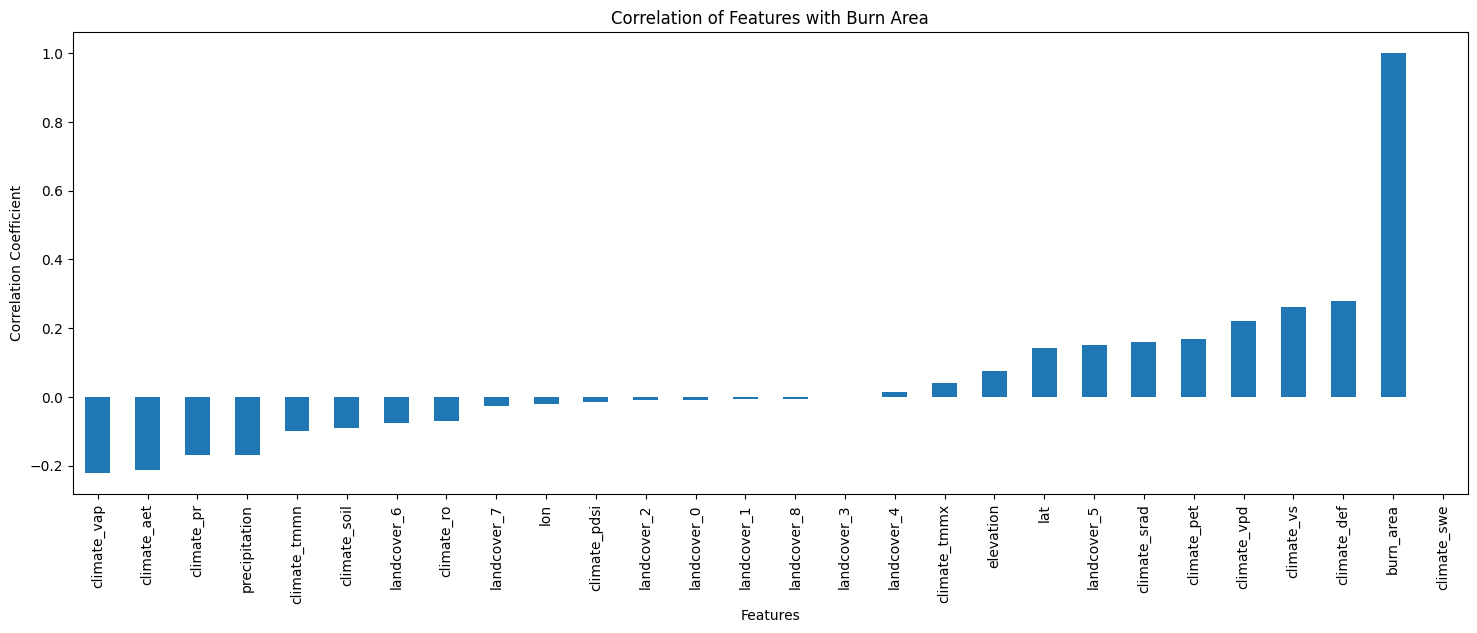

In [8]:
# Calculate correlation with target
correlation = train.select_dtypes(include=['number']).corr()['burn_area'].sort_values()

# Print correlation values
print(correlation)

# Plot correlation values
correlation.plot(kind='bar', figsize=(18, 6))
plt.title('Correlation of Features with Burn Area')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

##  Adding date features

In [9]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [10]:
train['date'][1]

Timestamp('2001-01-01 00:00:00')

In [11]:
train.head()

ID        lat        lon  burn_area  climate_aet  climate_def  \
0  0_2001-01-01 -15.858835  29.237029        0.0         1195            0   
1  1_2001-01-01 -15.858835  29.487029        0.0         1196            0   
2  2_2001-01-01 -15.858835  29.737029        0.0         1190            0   
3  3_2001-01-01 -15.858835  29.987029        0.0         1144            0   
4  4_2001-01-01 -15.858835  30.237029        0.0         1187            0   

   climate_pdsi  climate_pet  climate_pr  climate_ro  climate_soil  \
0           263         1195         206          10          1692   
1           232         1196         201          10          1859   
2           314         1190         192          10          1677   
3           321         1144         186          66          1061   
4           413         1187         186           9          1714   

   climate_srad  climate_swe  climate_tmmn  climate_tmmx  climate_vap  \
0          1861            0           211           317         2493   
1          1867            0           211           318         2497   
2          1861            0           208           317         2486   
3          1864            0           196           303         2333   
4          1852            0           204           314         2426   

   climate_vpd  climate_vs   elevation  landcover_0  landcover_1  landcover_2  \
0          111         141  413.474762          0.0          0.0     0.018654   
1          112         138  429.034543          0.0          0.0     0.000000   
2          109         141  477.246432          0.0          0.0     0.000000   
3           98         124  646.388681          0.0          0.0     0.000000   
4          109         145  582.340637          0.0          0.0     0.000000   

   landcover_3  landcover_4  landcover_5  landcover_6  landcover_7  \
0          0.0     0.714446     0.012174     0.244890     0.009836   
1          0.0     0.654783     0.000095     0.345121     0.000000   
2          0.0     0.516421     0.000000     0.483579     0.000000   
3          0.0     0.299000     0.163902     0.537098     0.000000   
4          0.0     0.277392     0.067742     0.654866     0.000000   

   landcover_8  precipitation       date  
0          0.0       0.256932 2001-01-01  
1          0.0       0.273093 2001-01-01  
2          0.0       0.285109 2001-01-01  
3          0.0       0.298418 2001-01-01  
4          0.0       0.315621 2001-01-01

In [12]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [13]:
# Group by month and calculate the mean burn_area
monthly_mean_burn_area = train.groupby('month')['burn_area'].mean().reset_index()

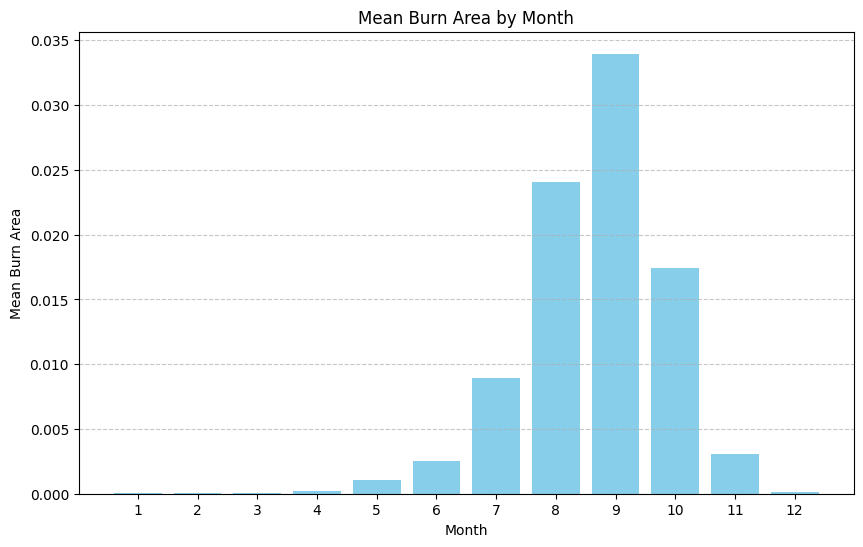

In [14]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_burn_area['month'], monthly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Month')
plt.xticks(monthly_mean_burn_area['month'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Group by year and calculate the mean burn_area
yearly_mean_burn_area = train.groupby('year')['burn_area'].mean().reset_index()

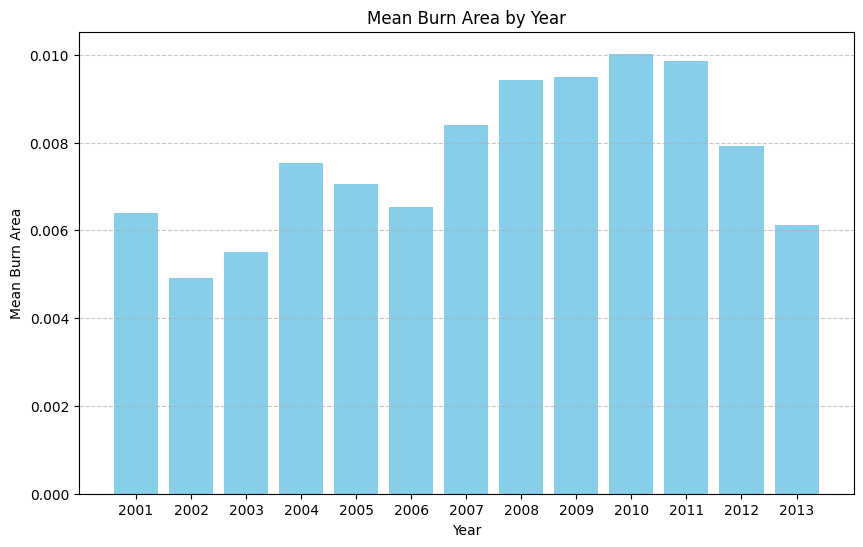

In [16]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_burn_area['year'], yearly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Year')
plt.xticks(yearly_mean_burn_area['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='date'>

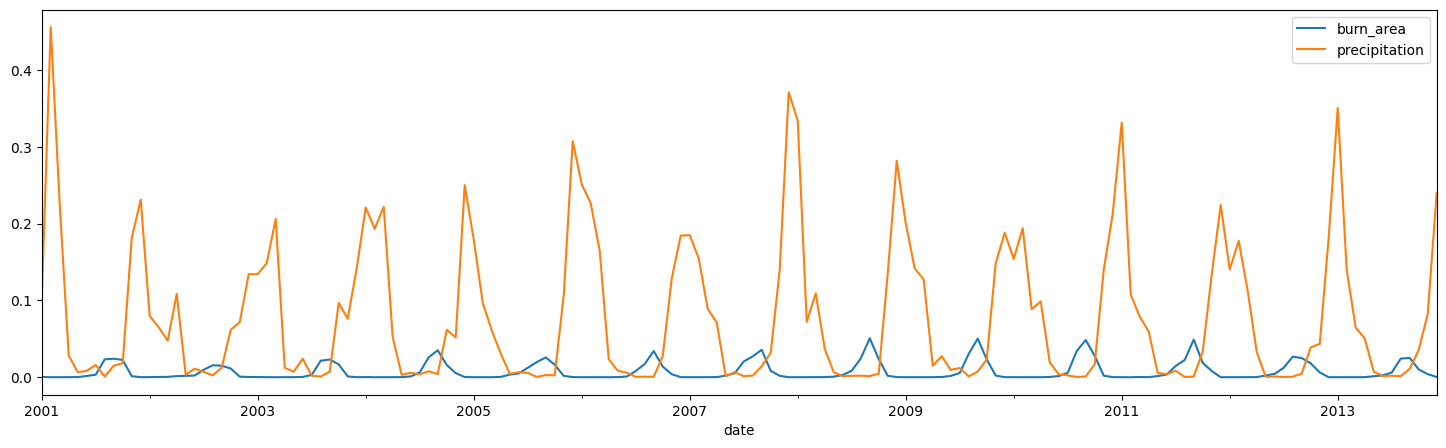

In [17]:
# Convert 'burn_area' to numeric, handling non-numeric values
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

# Now try plotting again
ax = train.groupby('date')['burn_area'].mean().reset_index().plot(y='burn_area', x='date', figsize=(18, 5))
train.groupby('date')['precipitation'].mean().reset_index().plot(y='precipitation', x='date', ax=ax)

In [18]:
# Combining Climate Variables:

# Hot and Dry Index
train['hot_and_dry'] = (train['climate_tmmx'] - train['climate_tmmn']) / (train['climate_pr'] + 1)
test['hot_and_dry'] = (test['climate_tmmx'] - test['climate_tmmn']) / (test['climate_pr'] + 1)

# Moisture Stress Index
train['moisture_stress'] = train['climate_aet'] / (train['climate_pr'] + train['climate_soil'] + 1)
test['moisture_stress'] = test['climate_aet'] / (test['climate_pr'] + test['climate_soil'] + 1)

# Temperature Range
train['temperature_range'] = train['climate_tmmx'] - train['climate_tmmn']
test['temperature_range'] = test['climate_tmmx'] - test['climate_tmmn']

# Drought Index
train['drought_index'] = train['climate_pdsi'] + train['climate_def']
test['drought_index'] = test['climate_pdsi'] + test['climate_def']

# Vapor Pressure Deficit to Temperature Ratio
train['vpd_temp_ratio'] = train['climate_vpd'] / (train['climate_tmmx'] + 1)
test['vpd_temp_ratio'] = test['climate_vpd'] / (test['climate_tmmx'] + 1)

# Temperature and Precipitation
train['temp_precip_interaction'] = (train['climate_tmmx'] - train['climate_tmmn']) * train['climate_pr']
test['temp_precip_interaction'] = (test['climate_tmmx'] - test['climate_tmmn']) * test['climate_pr']

# Vapor Pressure Deficit and Moisture Stress
train['vpd_moisture_interaction'] = train['vpd_temp_ratio'] * train['moisture_stress']
test['vpd_moisture_interaction'] = test['vpd_temp_ratio'] * test['moisture_stress']


In [19]:
#  combining climate temperature range with land cover types
for i in range(9):
    train[f'temp_range_landcover_{i}'] = train['temperature_range'] * train[f'landcover_{i}']
    test[f'temp_range_landcover_{i}'] = test['temperature_range'] * test[f'landcover_{i}']
    
# Example for combining precipitation with land cover types
for i in range(9):
    train[f'precipitation_landcover_{i}'] = train['precipitation'] * train[f'landcover_{i}']
    test[f'precipitation_landcover_{i}'] = test['precipitation'] * test[f'landcover_{i}']


In [20]:
train.describe(include="all")

ID           lat           lon     burn_area   climate_aet  \
count          83148  83148.000000  83148.000000  83148.000000  83148.000000   
unique         83148           NaN           NaN           NaN           NaN   
top     0_2001-01-01           NaN           NaN           NaN           NaN   
freq               1           NaN           NaN           NaN           NaN   
mean             NaN    -19.014557     29.860856      0.007632    484.491124   
min              NaN    -22.358835     25.487029      0.000000      0.000000   
25%              NaN    -20.358835     28.487029      0.000000     50.000000   
50%              NaN    -18.858835     29.987029      0.000000    302.000000   
75%              NaN    -17.858835     31.237029      0.000000    931.000000   
max              NaN    -15.858835     32.987029      0.843886   1713.000000   
std              NaN      1.588444      1.751090      0.029226    470.467480   

         climate_def  climate_pdsi   climate_pet    climate_pr    climate_ro  \
count   83148.000000  83148.000000  83148.000000  83148.000000  83148.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean      828.892721    -30.806237   1313.382992     54.576322      6.215134   
min         0.000000   -563.000000    587.000000      0.000000      0.000000   
25%       375.000000   -212.000000   1081.000000      1.000000      0.000000   
50%       858.000000   -108.000000   1290.000000     22.000000      1.000000   
75%      1211.000000    142.000000   1517.000000     87.000000      4.000000   
max      2614.000000    851.000000   2620.000000    501.000000    342.000000   
std       546.934469    235.802930    315.209838     71.997561     21.480399   

        climate_soil  climate_srad  climate_swe  climate_tmmn  climate_tmmx  \
count   83148.000000  83148.000000      83148.0  83148.000000  83148.000000   
unique           NaN           NaN          NaN           NaN           NaN   
top              NaN           NaN          NaN           NaN           NaN   
freq             NaN           NaN          NaN           NaN           NaN   
mean      305.477919   2281.967901          0.0    140.830303    285.288654   
min         1.000000   1167.000000          0.0     19.000000    139.000000   
25%        70.000000   2028.000000          0.0    103.000000    262.000000   
50%       149.000000   2272.000000          0.0    150.000000    287.000000   
75%       329.000000   2545.000000          0.0    177.000000    310.000000   
max      3319.000000   3170.000000          0.0    244.000000    400.000000   
std       400.956123    333.049616          0.0     44.631924     34.840502   

         climate_vap   climate_vpd    climate_vs     elevation   landcover_0  \
count   83148.000000  83148.000000  83148.000000  83148.000000  83148.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean     1554.532123    127.380117    208.414574    978.992612      0.006158   
min       704.000000     32.000000     48.000000    265.379418      0.000000   
25%      1139.000000     97.000000    174.000000    768.375959      0.000000   
50%      1544.000000    118.000000    205.000000   1022.813217      0.000000   
75%      1942.000000    149.000000    241.000000   1197.977194      0.000000   
max      2786.000000    344.000000    393.000000   1771.930689      0.828131   
std       458.461471     44.172381     47.550163    297.497348      0.053111   

         landcover_1   landcover_2   landcover_3   landcover_4   landcover_5  \
count   83148.000000  83148.000000  8.314800e+04  83148.000000  83148.000000   
unique           NaN      

In [21]:
train.head(10)

ID        lat        lon  burn_area  climate_aet  climate_def  \
0  0_2001-01-01 -15.858835  29.237029        0.0         1195            0   
1  1_2001-01-01 -15.858835  29.487029        0.0         1196            0   
2  2_2001-01-01 -15.858835  29.737029        0.0         1190            0   
3  3_2001-01-01 -15.858835  29.987029        0.0         1144            0   
4  4_2001-01-01 -15.858835  30.237029        0.0         1187            0   
5  5_2001-01-01 -16.108835  28.987029        0.0         1208            0   
6  6_2001-01-01 -16.108835  29.237029        0.0         1178            0   
7  7_2001-01-01 -16.108835  29.487029        0.0         1202            0   
8  8_2001-01-01 -16.108835  29.737029        0.0         1193            0   
9  9_2001-01-01 -16.108835  29.987029        0.0         1205            0   

   climate_pdsi  climate_pet  climate_pr  climate_ro  climate_soil  \
0           263         1195         206          10          1692   
1           232         1196         201          10          1859   
2           314         1190         192          10          1677   
3           321         1144         186          66          1061   
4           413         1187         186           9          1714   
5           255         1208         194          10          1242   
6           272         1178         206          10          1623   
7           262         1202         210          11          1927   
8           308         1193         195          10          1673   
9           322         1205         176          28          1304   

   climate_srad  climate_swe  climate_tmmn  climate_tmmx  climate_vap  \
0          1861            0           211           317         2493   
1          1867            0           211           318         2497   
2          1861            0           208           317         2486   
3          1864            0           196           303         2333   
4          1852            0           204           314         2426   
5          1931            0           210           316         2474   
6          1937            0           205           310         2449   
7          1913            0           204           310         2431   
8          1905            0           201           307         2396   
9          1922            0           205           315         2458   

   climate_vpd  climate_vs   elevation  landcover_0  landcover_1  landcover_2  \
0          111         141  413.474762          0.0          0.0     0.018654   
1          112         138  429.034543          0.0          0.0     0.000000   
2          109         141  477.246432          0.0          0.0     0.000000   
3           98         124  646.388681          0.0          0.0     0.000000   
4          109         145  582.340637          0.0          0.0     0.000000   
5          111         125  456.456370          0.0          0.0     0.006127   
6          102         111  568.320654          0.0          0.0     0.000000   
7          104         145  616.567786          0.0          0.0     0.000000   
8          101         148  671.964140          0.0          0.0     0.000000   
9          108         132  551.071061          0.0          0.0     0.000000   

   landcover_3  landcover_4  landcover_5  landcover_6  landcover_7  \
0          0.0     0.714446     0.012174     0.244890     0.009836   
1          0.0     0.654783     0.000095     0.345121     0.000000   
2          0.0     0.516421     0.000000     0.483579     0.000000   
3          0.0     0.299000     0.163902     0.537098     0.000000   
4          0.0     0.277392     0.067742     0.654866     0.000000   
5          0.0     0.624927     0.009568     0.359205     0.000172   
6          0.0     0.453779     0.220409     0.325812     0.000000   
7          0.0     0.176966     0.382653     0.440381     0.000000   
8          0.0     0.476697     0.097168     0.426136    

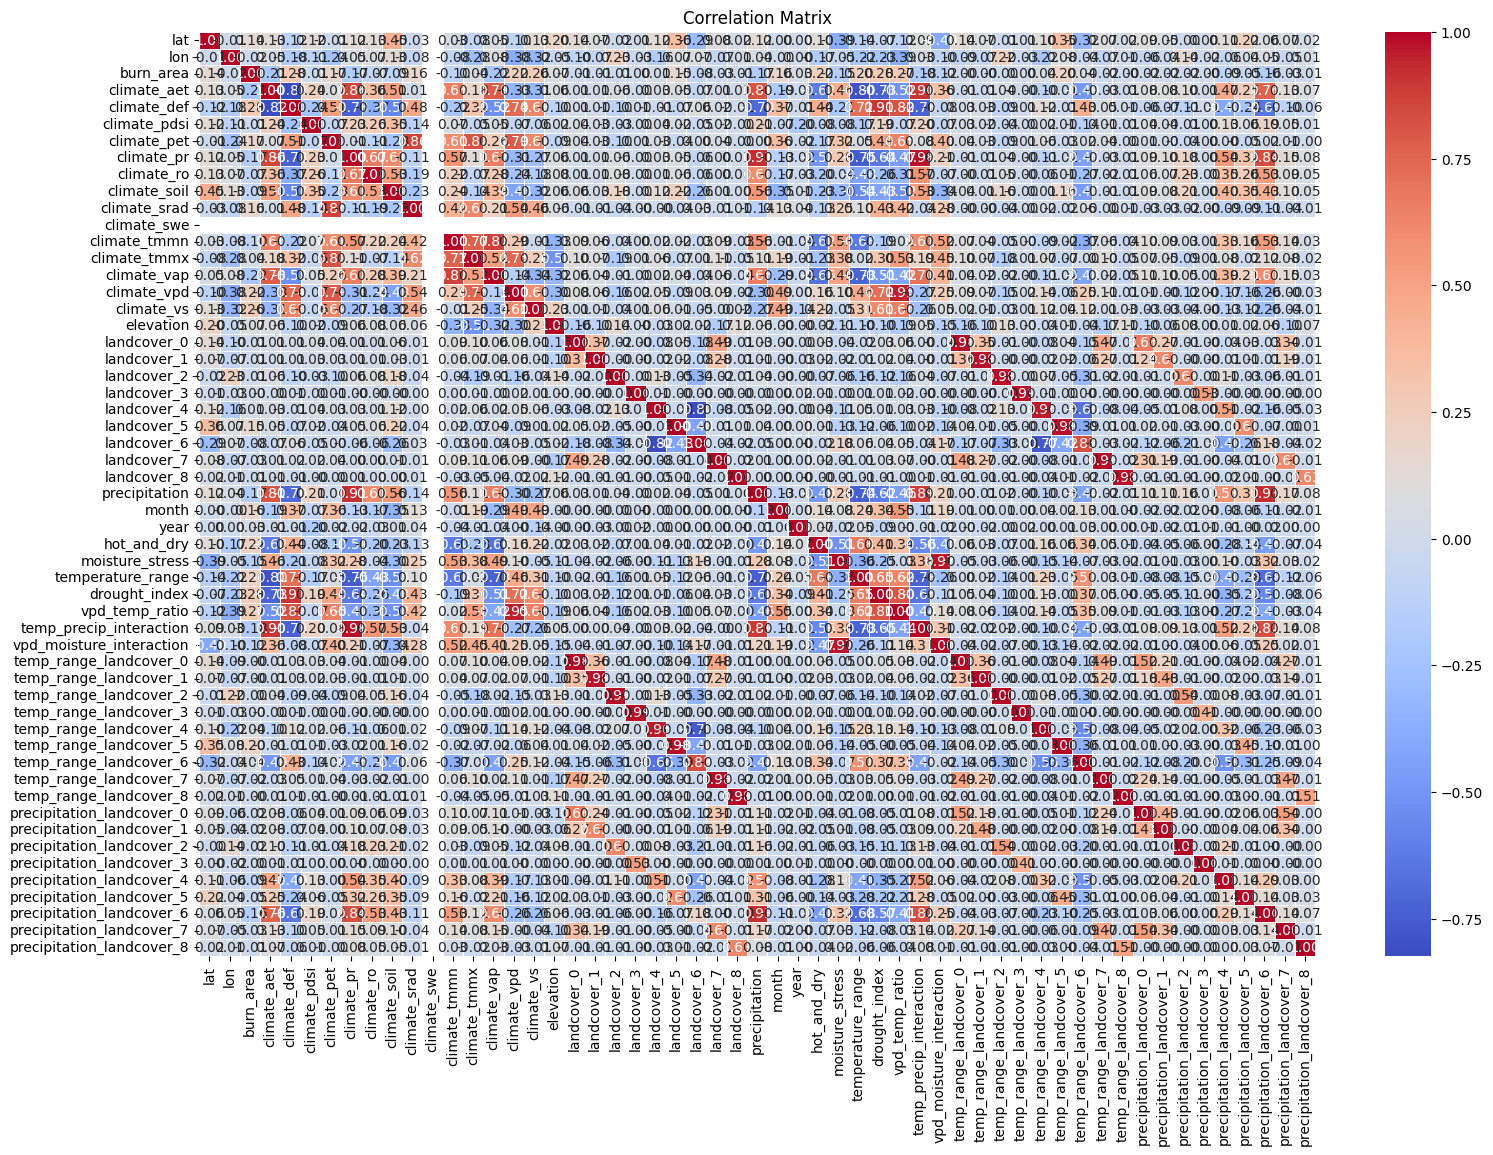

burn_area                    1.000000
climate_def                  0.279511
drought_index                0.276587
vpd_temp_ratio               0.267578
climate_vs                   0.261562
climate_vpd                  0.219974
hot_and_dry                  0.216532
temperature_range            0.203742
temp_range_landcover_5       0.195382
climate_pet                  0.168871
month                        0.162697
climate_srad                 0.160517
landcover_5                  0.151957
lat                          0.140848
elevation                    0.074576
temp_range_landcover_4       0.044624
temp_range_landcover_6       0.043967
climate_tmmx                 0.040500
year                         0.032384
landcover_4                  0.013846
temp_range_landcover_3       0.001612
landcover_3                  0.000964
temp_range_landcover_8      -0.001320
precipitation_landcover_3   -0.001437
temp_range_landcover_2      -0.002317
temp_range_landcover_1      -0.003275
temp_range_l

In [22]:

# Ensure only numeric columns are selected
numeric_columns = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Print the correlation values with burn_area
burn_area_corr = correlation_matrix['burn_area'].sort_values(ascending=False)
print(burn_area_corr)


## Adding more features - some ideas




*   Read the list of climate variables and what they mean. See if you can combine them in interesting ways - perhaps a 'hot_and_dry' metric...
*   Fire depends on some processes that take a long time - for example, there may be more fuel if the previous growing season was a good one. Consider some lagged variables to give the model some inputs for what came before the current month.
*   Make some categorical features - 'dominant_land_type' or 'is_peak_rainfall'.
*   ...



In [23]:
# Define the number of periods to lag
num_periods = 6  # Example: lagging by 1 month

# List of variables to create lagged versions for
variables = ['climate_aet', 'climate_def', 'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_soil',
             'climate_srad', 'climate_swe', 'temperature_range', 'drought_index', 'vpd_temp_ratio',
             'temp_precip_interaction', 'vpd_moisture_interaction', 'precipitation']

# Create lagged features for train dataset
for col in variables:
    train[f'{col}_lag{num_periods}'] = train.groupby('lat')[col].shift(num_periods)

# Create lagged features for test dataset
for col in variables:
    test[f'{col}_lag{num_periods}'] = test.groupby('lat')[col].shift(num_periods)

# Verify the columns in the train dataset
print("Train dataset columns:")
print(train.columns)

# Verify the columns in the test dataset
print("Test dataset columns:")
print(test.columns)

Train dataset columns:
Index(['ID', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'date', 'month', 'year', 'hot_and_dry',
       'moisture_stress', 'temperature_range', 'drought_index',
       'vpd_temp_ratio', 'temp_precip_interaction', 'vpd_moisture_interaction',
       'temp_range_landcover_0', 'temp_range_landcover_1',
       'temp_range_landcover_2', 'temp_range_landcover_3',
       'temp_range_landcover_4', 'temp_range_landcover_5',
       'temp_range_landcover_6', 'temp_range_landcover_7',
       'temp_range_landcover_8', 'precipitation_landcover_0',
       'precipitation_landcover_1', 

In [24]:
train.head()

ID        lat        lon  burn_area  climate_aet  climate_def  \
0  0_2001-01-01 -15.858835  29.237029        0.0         1195            0   
1  1_2001-01-01 -15.858835  29.487029        0.0         1196            0   
2  2_2001-01-01 -15.858835  29.737029        0.0         1190            0   
3  3_2001-01-01 -15.858835  29.987029        0.0         1144            0   
4  4_2001-01-01 -15.858835  30.237029        0.0         1187            0   

   climate_pdsi  climate_pet  climate_pr  climate_ro  climate_soil  \
0           263         1195         206          10          1692   
1           232         1196         201          10          1859   
2           314         1190         192          10          1677   
3           321         1144         186          66          1061   
4           413         1187         186           9          1714   

   climate_srad  climate_swe  climate_tmmn  climate_tmmx  climate_vap  \
0          1861            0           211           317         2493   
1          1867            0           211           318         2497   
2          1861            0           208           317         2486   
3          1864            0           196           303         2333   
4          1852            0           204           314         2426   

   climate_vpd  climate_vs   elevation  landcover_0  landcover_1  landcover_2  \
0          111         141  413.474762          0.0          0.0     0.018654   
1          112         138  429.034543          0.0          0.0     0.000000   
2          109         141  477.246432          0.0          0.0     0.000000   
3           98         124  646.388681          0.0          0.0     0.000000   
4          109         145  582.340637          0.0          0.0     0.000000   

   landcover_3  landcover_4  landcover_5  landcover_6  landcover_7  \
0          0.0     0.714446     0.012174     0.244890     0.009836   
1          0.0     0.654783     0.000095     0.345121     0.000000   
2          0.0     0.516421     0.000000     0.483579     0.000000   
3          0.0     0.299000     0.163902     0.537098     0.000000   
4          0.0     0.277392     0.067742     0.654866     0.000000   

   landcover_8  precipitation       date  month  year  hot_and_dry  \
0          0.0       0.256932 2001-01-01      1  2001     0.512077   
1          0.0       0.273093 2001-01-01      1  2001     0.529703   
2          0.0       0.285109 2001-01-01      1  2001     0.564767   
3          0.0       0.298418 2001-01-01      1  2001     0.572193   
4          0.0       0.315621 2001-01-01      1  2001     0.588235   

   moisture_stress  temperature_range  drought_index  vpd_temp_ratio  \
0         0.629279                106            263        0.349057   
1         0.580301                107            232        0.351097   
2         0.636364                109            314        0.342767   
3         0.916667                107            321        0.322368   
4         0.624408                110            413        0.346032   

   temp_precip_interaction  vpd_moisture_interaction  temp_range_landcover_0  \
0                    21836                  0.219654                     0.0   
1                    21507                  0.203742                     0.0   
2                    20928                  0.218125                     0.0   
3                    19902                  0.295504                     0.0   
4                    20460                  0.216065                     0.0   

   temp_range_landcover_1  temp_range_landcover_2  temp_range_landcover_3  \
0                     0.0                1.977356                     0.0   
1                     0.0                0.000000                     0.0   
2                     0.0                0.000000                     0.0   
3                     0.0                0.000000                     0.0   
4                     0.0                0.000000       

In [25]:
# Data Split for Validation
train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
print(train.shape, valid.shape)

# Define input and output columns
in_cols = [col for col in train.columns if col not in ['ID', 'date', 'burn_area']]
target_col = 'burn_area'

# Prepare training and validation data
X_train = train[in_cols]
y_train = train[target_col]
X_valid = valid[in_cols]
y_valid = valid[target_col]


(63798, 71) (18655, 71)


In [26]:
# Create and fit the RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)  # Adjust n_estimators for better performance
rf_model.fit(X_train, y_train)
# Make predictions with RandomForest model
rf_preds = rf_model.predict(X_valid)

# Score the RandomForest model
rf_rmse = mean_squared_error(y_valid, rf_preds)**0.5
print('RandomForest RMSE:', rf_rmse)


RandomForest RMSE: 0.02350258078023484


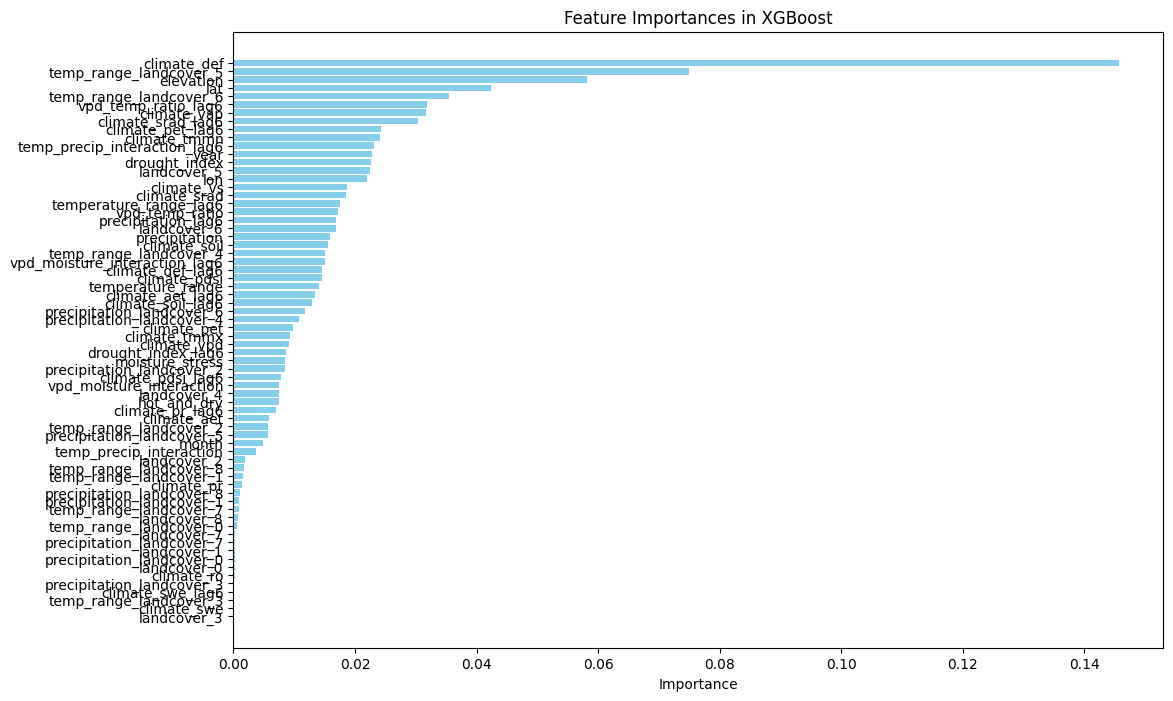

Feature  Importance
3                     climate_def    0.145745
41         temp_range_landcover_5    0.074921
16                      elevation    0.058126
0                             lat    0.042368
42         temp_range_landcover_6    0.035418
64            vpd_temp_ratio_lag6    0.031777
13                    climate_vap    0.031707
60              climate_srad_lag6    0.030367
57               climate_pet_lag6    0.024245
11                   climate_tmmn    0.024160
65   temp_precip_interaction_lag6    0.023181
28                           year    0.022775
32                  drought_index    0.022553
22                    landcover_5    0.022449
1                             lon    0.021901
15                     climate_vs    0.018748
9                    climate_srad    0.018558
62         temperature_range_lag6    0.017500
33                 vpd_temp_ratio    0.017196
67             precipitation_lag6    0.016895
23                    landcover_6    0.016875
26                  precipitation    0.015875
8                    climate_soil    0.015550
40         temp_range_landcover_4    0.015114
66  vpd_moisture_interaction_lag6    0.015072
55               climate_def_lag6    0.014591
4                    climate_pdsi    0.014491
31              temperature_range    0.014118
54               climate_aet_lag6    0.013363
59              climate_soil_lag6    0.012855
51      precipitation_landcover_6    0.011721
49      precipitation_landcover_4    0.010783
5                     climate_pet    0.009746
12                   climate_tmmx    0.009234
14                    climate_vpd    0.009190
63             drought_index_lag6    0.008684
30                moisture_stress    0.008553
47      precipitation_landcover_2    0.008442
56              climate_pdsi_lag6    0.007899
35       vpd_moisture_interaction    0.007562
21                    landcover_4    0.007486
29                    hot_and_dry    0.007431
58                climate_pr_lag6    0.006966
2                     climate_aet    0.005805
38         temp_range_landcover_2    0.005645
50      precipitation_landcover_5    0.005633
27                          month    0.004823
34        temp_precip_interaction    0.003668
19                    landcover_2    0.001835
44         temp_range_landcover_8    0.001704
37         temp_range_landcover_1    0.001571
6                      climate_pr    0.001395
53      precipitation_landcover_8    0.001143
46      precipitation_landcover_1    0.000905
43         temp_range_landcover_7    0.000853
25                    landcover_8    0.000667
36         temp_range_landcover_0    0.000643
24                    landcover_7    0.000298
52      precipitation_landcover_7    0.000275
18                    landcover_1    0.000268
45      precipitation_landcover_0    0.000264
17                    landcover_0    0.000237
7                      climate_ro    0.000179
48      precipitation_landcover_3    0.000000
61               climate_swe_lag6    0.000000
39         temp_range_landcover_3    0.000000
10                    climate_swe    0.000000
20                    landcover_3    0.000000

In [27]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
xgb_importance_df = pd.DataFrame({
    'Feature': in_cols,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost')
plt.gca().invert_yaxis()
plt.show()

xgb_importance_df

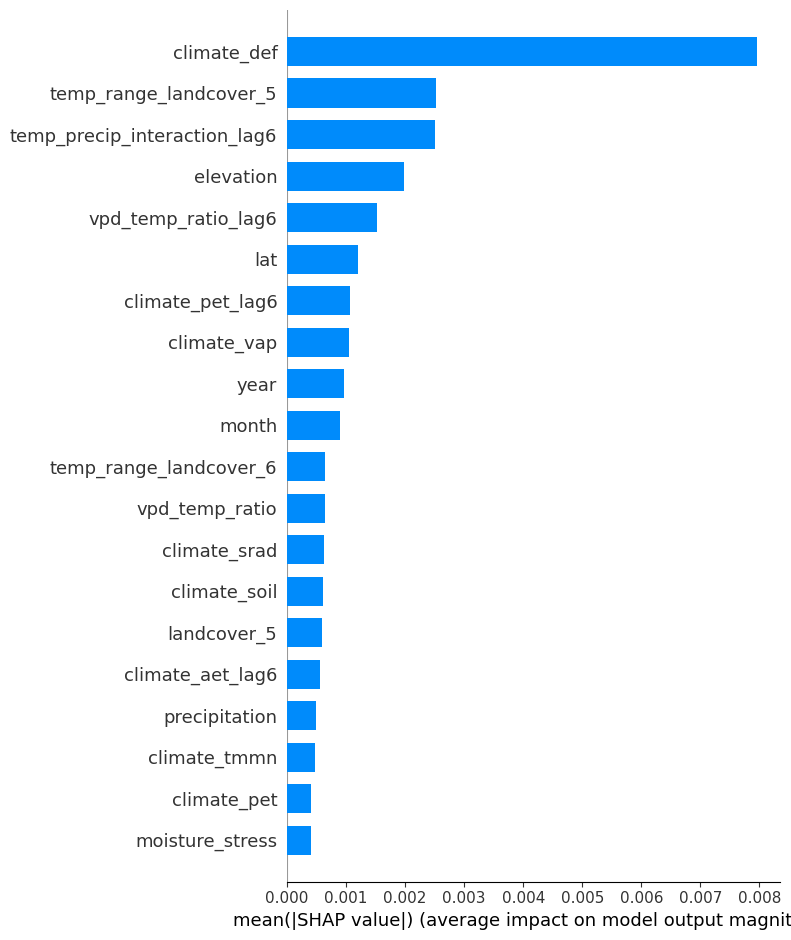

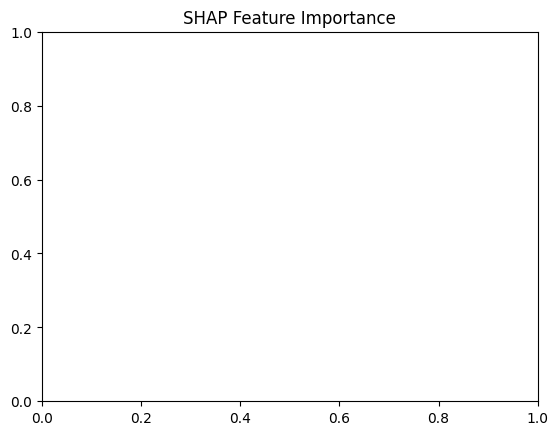

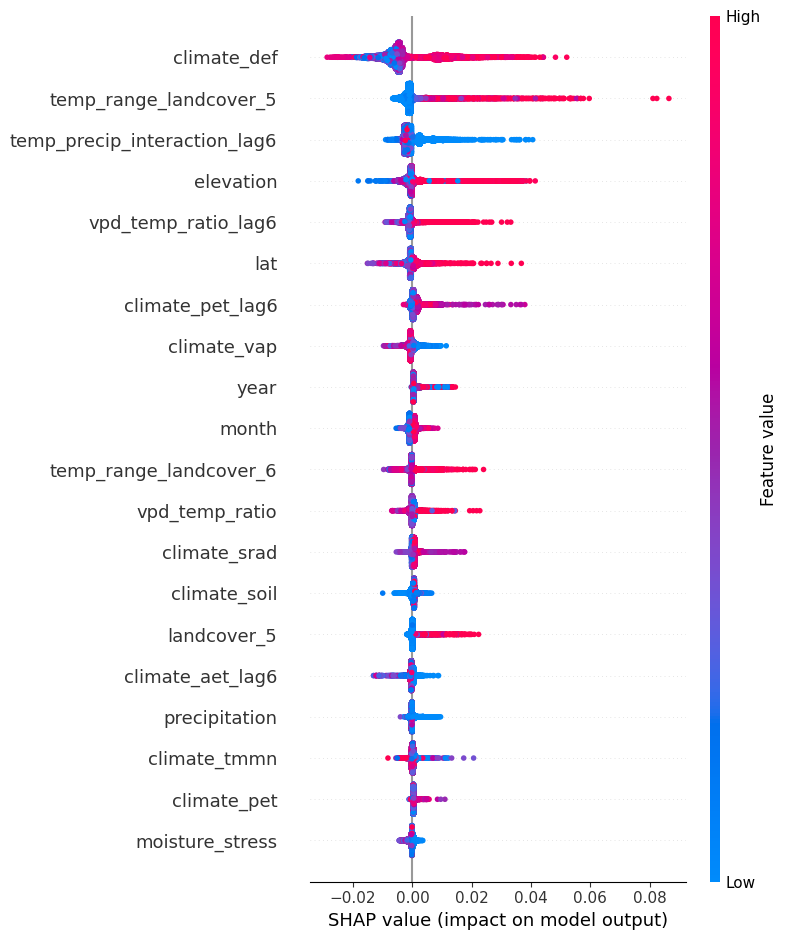

In [28]:
# Ensure SHAP uses logit scale for xgboost
explainer = shap.Explainer(rf_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valid)

# Plot summary plot for SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.show()

# Detailed SHAP summary plot
shap.summary_plot(shap_values, X_valid)

RandomForest RMSE: 0.02350258078023484


## XGBoost

In [29]:
# Create and fit the XGBoost model
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
# Make predictions with XGBoost model
xgb_preds = xgb_model.predict(X_valid)

# Score the XGBoost model
xgb_rmse = mean_squared_error(y_valid, xgb_preds)**0.5
print('XGBoost RMSE:', xgb_rmse)


XGBoost RMSE: 0.024562540750571446


XGBoost RMSE: 0.026042697401728435

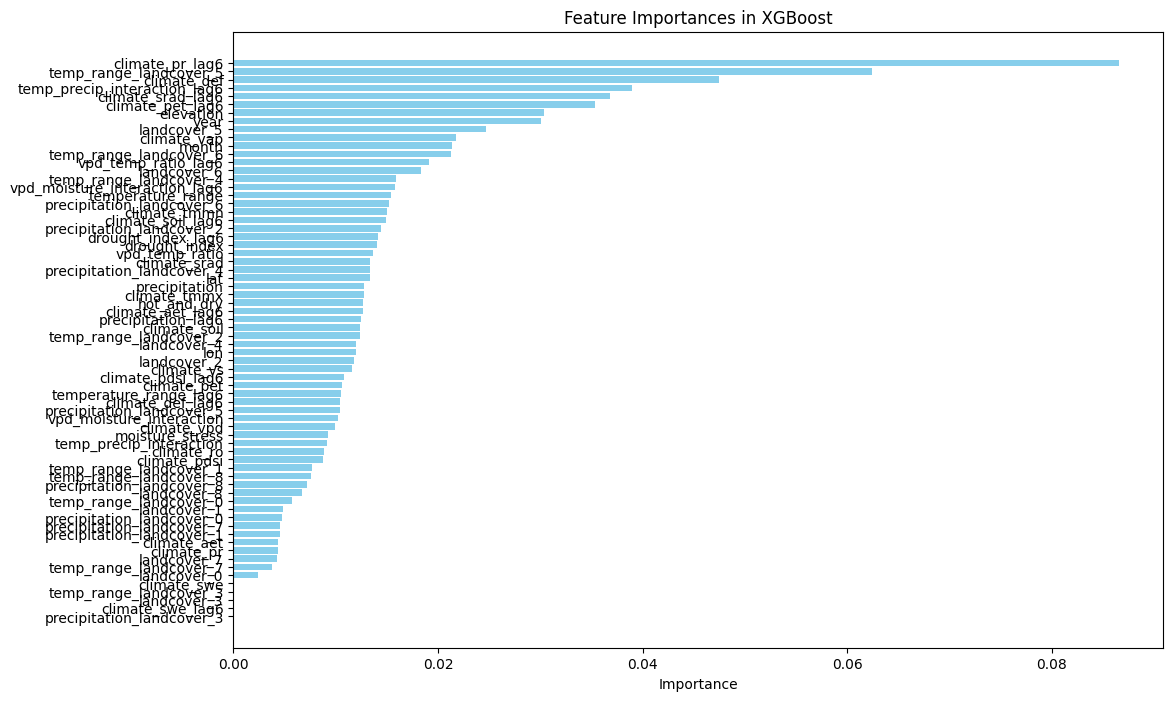

Feature  Importance
58                climate_pr_lag6    0.086581
41         temp_range_landcover_5    0.062410
3                     climate_def    0.047494
65   temp_precip_interaction_lag6    0.038961
60              climate_srad_lag6    0.036853
57               climate_pet_lag6    0.035296
16                      elevation    0.030320
28                           year    0.030081
22                    landcover_5    0.024709
13                    climate_vap    0.021774
27                          month    0.021357
42         temp_range_landcover_6    0.021228
64            vpd_temp_ratio_lag6    0.019157
23                    landcover_6    0.018375
40         temp_range_landcover_4    0.015877
66  vpd_moisture_interaction_lag6    0.015756
31              temperature_range    0.015420
51      precipitation_landcover_6    0.015212
11                   climate_tmmn    0.015010
59              climate_soil_lag6    0.014885
47      precipitation_landcover_2    0.014414
63             drought_index_lag6    0.014154
32                  drought_index    0.014032
33                 vpd_temp_ratio    0.013646
9                    climate_srad    0.013375
49      precipitation_landcover_4    0.013329
0                             lat    0.013302
26                  precipitation    0.012772
12                   climate_tmmx    0.012752
29                    hot_and_dry    0.012705
54               climate_aet_lag6    0.012672
67             precipitation_lag6    0.012421
8                    climate_soil    0.012340
38         temp_range_landcover_2    0.012323
21                    landcover_4    0.011979
1                             lon    0.011971
19                    landcover_2    0.011789
15                     climate_vs    0.011634
56              climate_pdsi_lag6    0.010798
5                     climate_pet    0.010604
62         temperature_range_lag6    0.010536
55               climate_def_lag6    0.010453
50      precipitation_landcover_5    0.010447
35       vpd_moisture_interaction    0.010225
14                    climate_vpd    0.009876
30                moisture_stress    0.009276
34        temp_precip_interaction    0.009107
7                      climate_ro    0.008874
4                    climate_pdsi    0.008774
37         temp_range_landcover_1    0.007683
44         temp_range_landcover_8    0.007555
53      precipitation_landcover_8    0.007236
25                    landcover_8    0.006737
36         temp_range_landcover_0    0.005713
18                    landcover_1    0.004838
45      precipitation_landcover_0    0.004754
52      precipitation_landcover_7    0.004546
46      precipitation_landcover_1    0.004504
2                     climate_aet    0.004389
6                      climate_pr    0.004306
24                    landcover_7    0.004250
43         temp_range_landcover_7    0.003797
17                    landcover_0    0.002351
10                    climate_swe    0.000000
39         temp_range_landcover_3    0.000000
20                    landcover_3    0.000000
61               climate_swe_lag6    0.000000
48      precipitation_landcover_3    0.000000

In [30]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
xgb_importance_df = pd.DataFrame({
    'Feature': in_cols,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost')
plt.gca().invert_yaxis()
plt.show()

xgb_importance_df

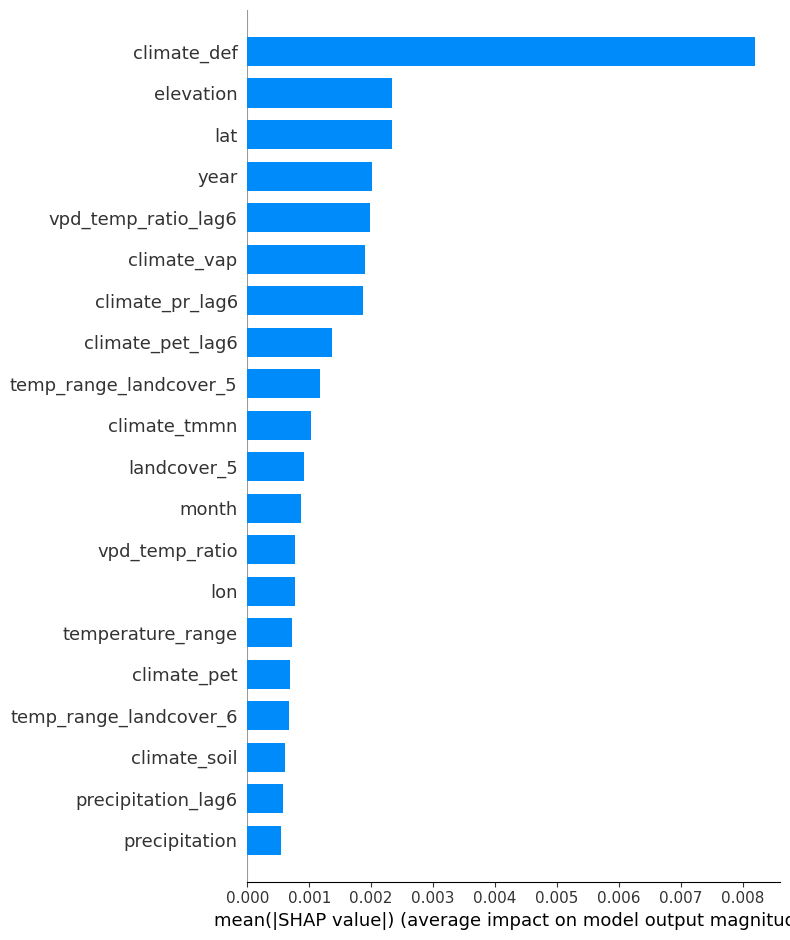

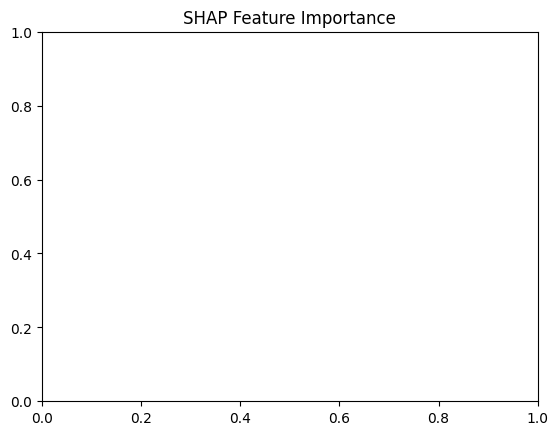

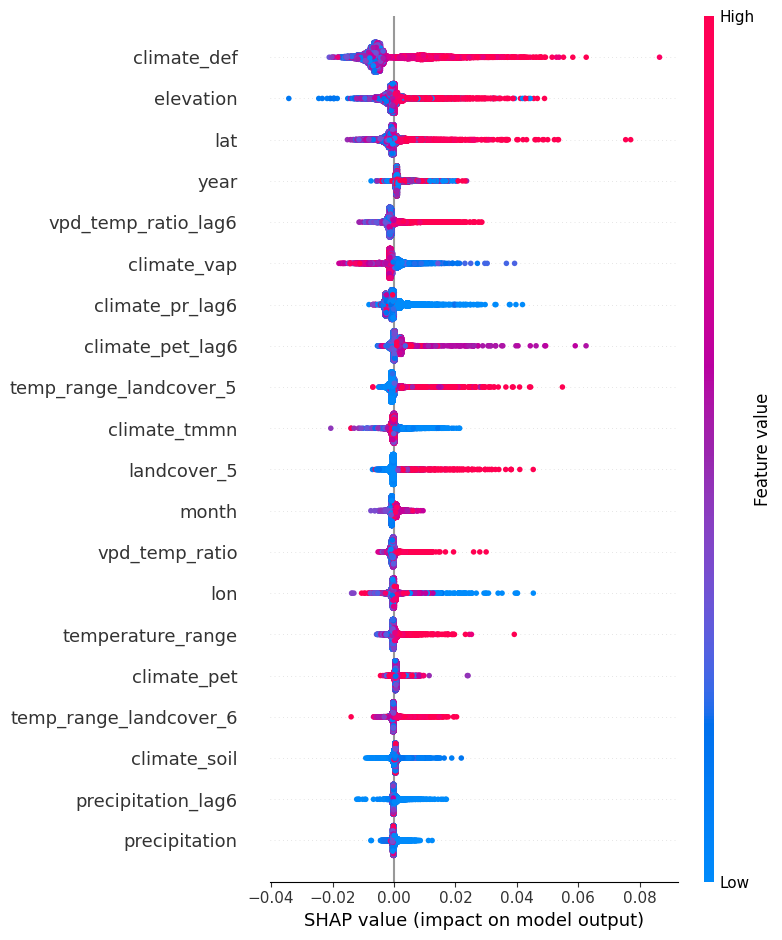

In [31]:
# Ensure SHAP uses logit scale for xgboost
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valid)

# Plot summary plot for SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.title('SHAP Feature Importance')
plt.show()

# Detailed SHAP summary plot
shap.summary_plot(shap_values, X_valid)